# <a id='toc1_'></a>[Trading Strategy](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Trading Strategy](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [Net-zero portfolio](#toc4_)    
  - [Tables](#toc4_1_)    
    - [Decile performance](#toc4_1_1_)    
    - [Drawdown, turnover, and max 1-month loss](#toc4_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pathlib import Path

import sys
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))
from libs.functions import *

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
preds = pd.read_csv('data/predictions_amadl.csv')
preds.rename(columns={'Unnamed: 0': 'index_original'}, inplace=True)
# preds.columns = preds.columns.str.lower()
preds['timestamp'] = pd.to_datetime(preds['timestamp']) + pd.offsets.MonthEnd(1) # add one month as the target is the prediction for the next month
# preds['y_true'] = preds['y_true'] + ((1+preds['discount'])**(1/12)-1) # add back the short rate to get the true return

data_raw = pd.read_csv('data/data.csv')
discount = data_raw[['timestamp', 'discount']].copy()
discount['timestamp'] = pd.to_datetime(discount['timestamp'])
discount['discount_m'] = (1 + discount['discount'])**(1/12) - 1

omxc25_tickers = pd.read_csv('data/omxc25_constit.csv')
omxc25_tickers = omxc25_tickers[['timestamp', 'ticker']]
omxc25_tickers['in_c25'] = True
omxc25_tickers['timestamp'] = pd.to_datetime(omxc25_tickers['timestamp'])

omxc25_price = pd.read_csv('data/omxc25_price.csv')
omxc25_price['timestamp'] = pd.to_datetime(omxc25_price['timestamp'])
omxc25_price = omxc25_price[(omxc25_price['timestamp'] >= '2021-01-01') & (omxc25_price['timestamp'] <= '2024-12-31')]

omxcb_tickers = pd.read_csv('data/omxcb_constit.csv')
omxcb_tickers = omxcb_tickers[['timestamp', 'ticker']]
omxcb_tickers['timestamp'] = pd.to_datetime(omxcb_tickers['timestamp'])
omxcb_tickers['in_cb'] = True 

omxcb_price = pd.read_csv('data/omxcb_price.csv')
omxcb_price['timestamp'] = pd.to_datetime(omxcb_price['timestamp'])
omxcb_price = omxcb_price[(omxcb_price['timestamp'] >= '2021-01-01') & (omxcb_price['timestamp'] <= '2024-12-31')]

In [3]:
df = (preds
      .merge(omxc25_tickers, on=['ticker','timestamp'], how='left')
      .merge(omxcb_tickers, on=['ticker','timestamp'], how='left')
)
df['in_c25'] = np.where(df['in_c25'].isna(), False, df['in_c25'])
df['in_cb'] = np.where(df['in_cb'].isna(), False, df['in_cb'])

df = df[df['in_cb'] == True]
df = df[df['in_c25'] == True]

In [4]:
# rename columns
df.columns = df.columns.str.replace('MLP-AMADL', 'AMADL')

# <a id='toc4_'></a>[Net-zero portfolio](#toc0_)

In [5]:
# calculate portfolio returns
df.sort_values(by=['timestamp'])
port_10_1 = pd.DataFrame()
models = [
    # 'OLS','LASSO',
          'MLP','MLP-Pyr', 
          'AMADL', 'AMADL-Pyr'
          ]
n_tiles = 5

for model in models:
    for dir in ['long', 'short']:
        tmp = df.copy(deep=True)
        tmp = tmp[['timestamp', model, 'y_true']]
        tmp['decile'] = df.groupby(['timestamp'])[model].transform(lambda x: pd.qcut(x, n_tiles, labels=False))
        # create action column based on decile
        if dir == 'long':
            tmp['action'] = np.where(tmp['decile'] == n_tiles-1, 1, 0)
        else:
            tmp['action'] = np.where(tmp['decile'] == 0, -1, 0)
        # find stocks in position
        tmp[f'n_dir'] = (tmp['action'] == (1 if dir == 'long' else -1)).astype(int)
        tmp[f'n_dir'] = tmp.groupby('timestamp')[f'n_dir'].transform('sum')
        
        # calculate return for the direction (equal weighted)  
        tmp[f'{model}_{dir}'] = tmp['action']*tmp['y_true']/tmp[f'n_dir'] # multiply by action to get the return for the direction

        # sum the returns for each month
        tmp = tmp.groupby('timestamp')[f'{model}_{dir}'].sum().reset_index()
        # calculate cumulative return and percentage return
        tmp[f'{model}_{dir}'] = tmp[f'{model}_{dir}'] + 1
        tmp[f'{model}_{dir}_cum'] = tmp[f'{model}_{dir}'].cumprod() * 100
        tmp[f'{model}_{dir}'] = tmp[f'{model}_{dir}'] - 1

        port_10_1 = pd.concat([port_10_1, tmp], axis=1)
port_10_1 = port_10_1.loc[:, ~port_10_1.columns.duplicated()]

# start with an initial value of 100
port_10_1.loc[-1] = [pd.Timestamp('2021-01-01'), 
                    #  np.nan, 100, np.nan, 100, # OLS 
                    #  np.nan, 100, np.nan, 100, # LASSO
                     np.nan, 100, np.nan, 100, # MLP
                     np.nan, 100, np.nan, 100, # MLP-Pyr
                     np.nan, 100, np.nan, 100, # MLP-AMADL
                     np.nan, 100, np.nan, 100, # MLP-AMADL-Pyr
                     ]
port_10_1 = port_10_1.sort_index().reset_index(drop=True)

# rename columns
port_10_1.columns = port_10_1.columns.str.replace('MLP-AMADL', 'AMADL')

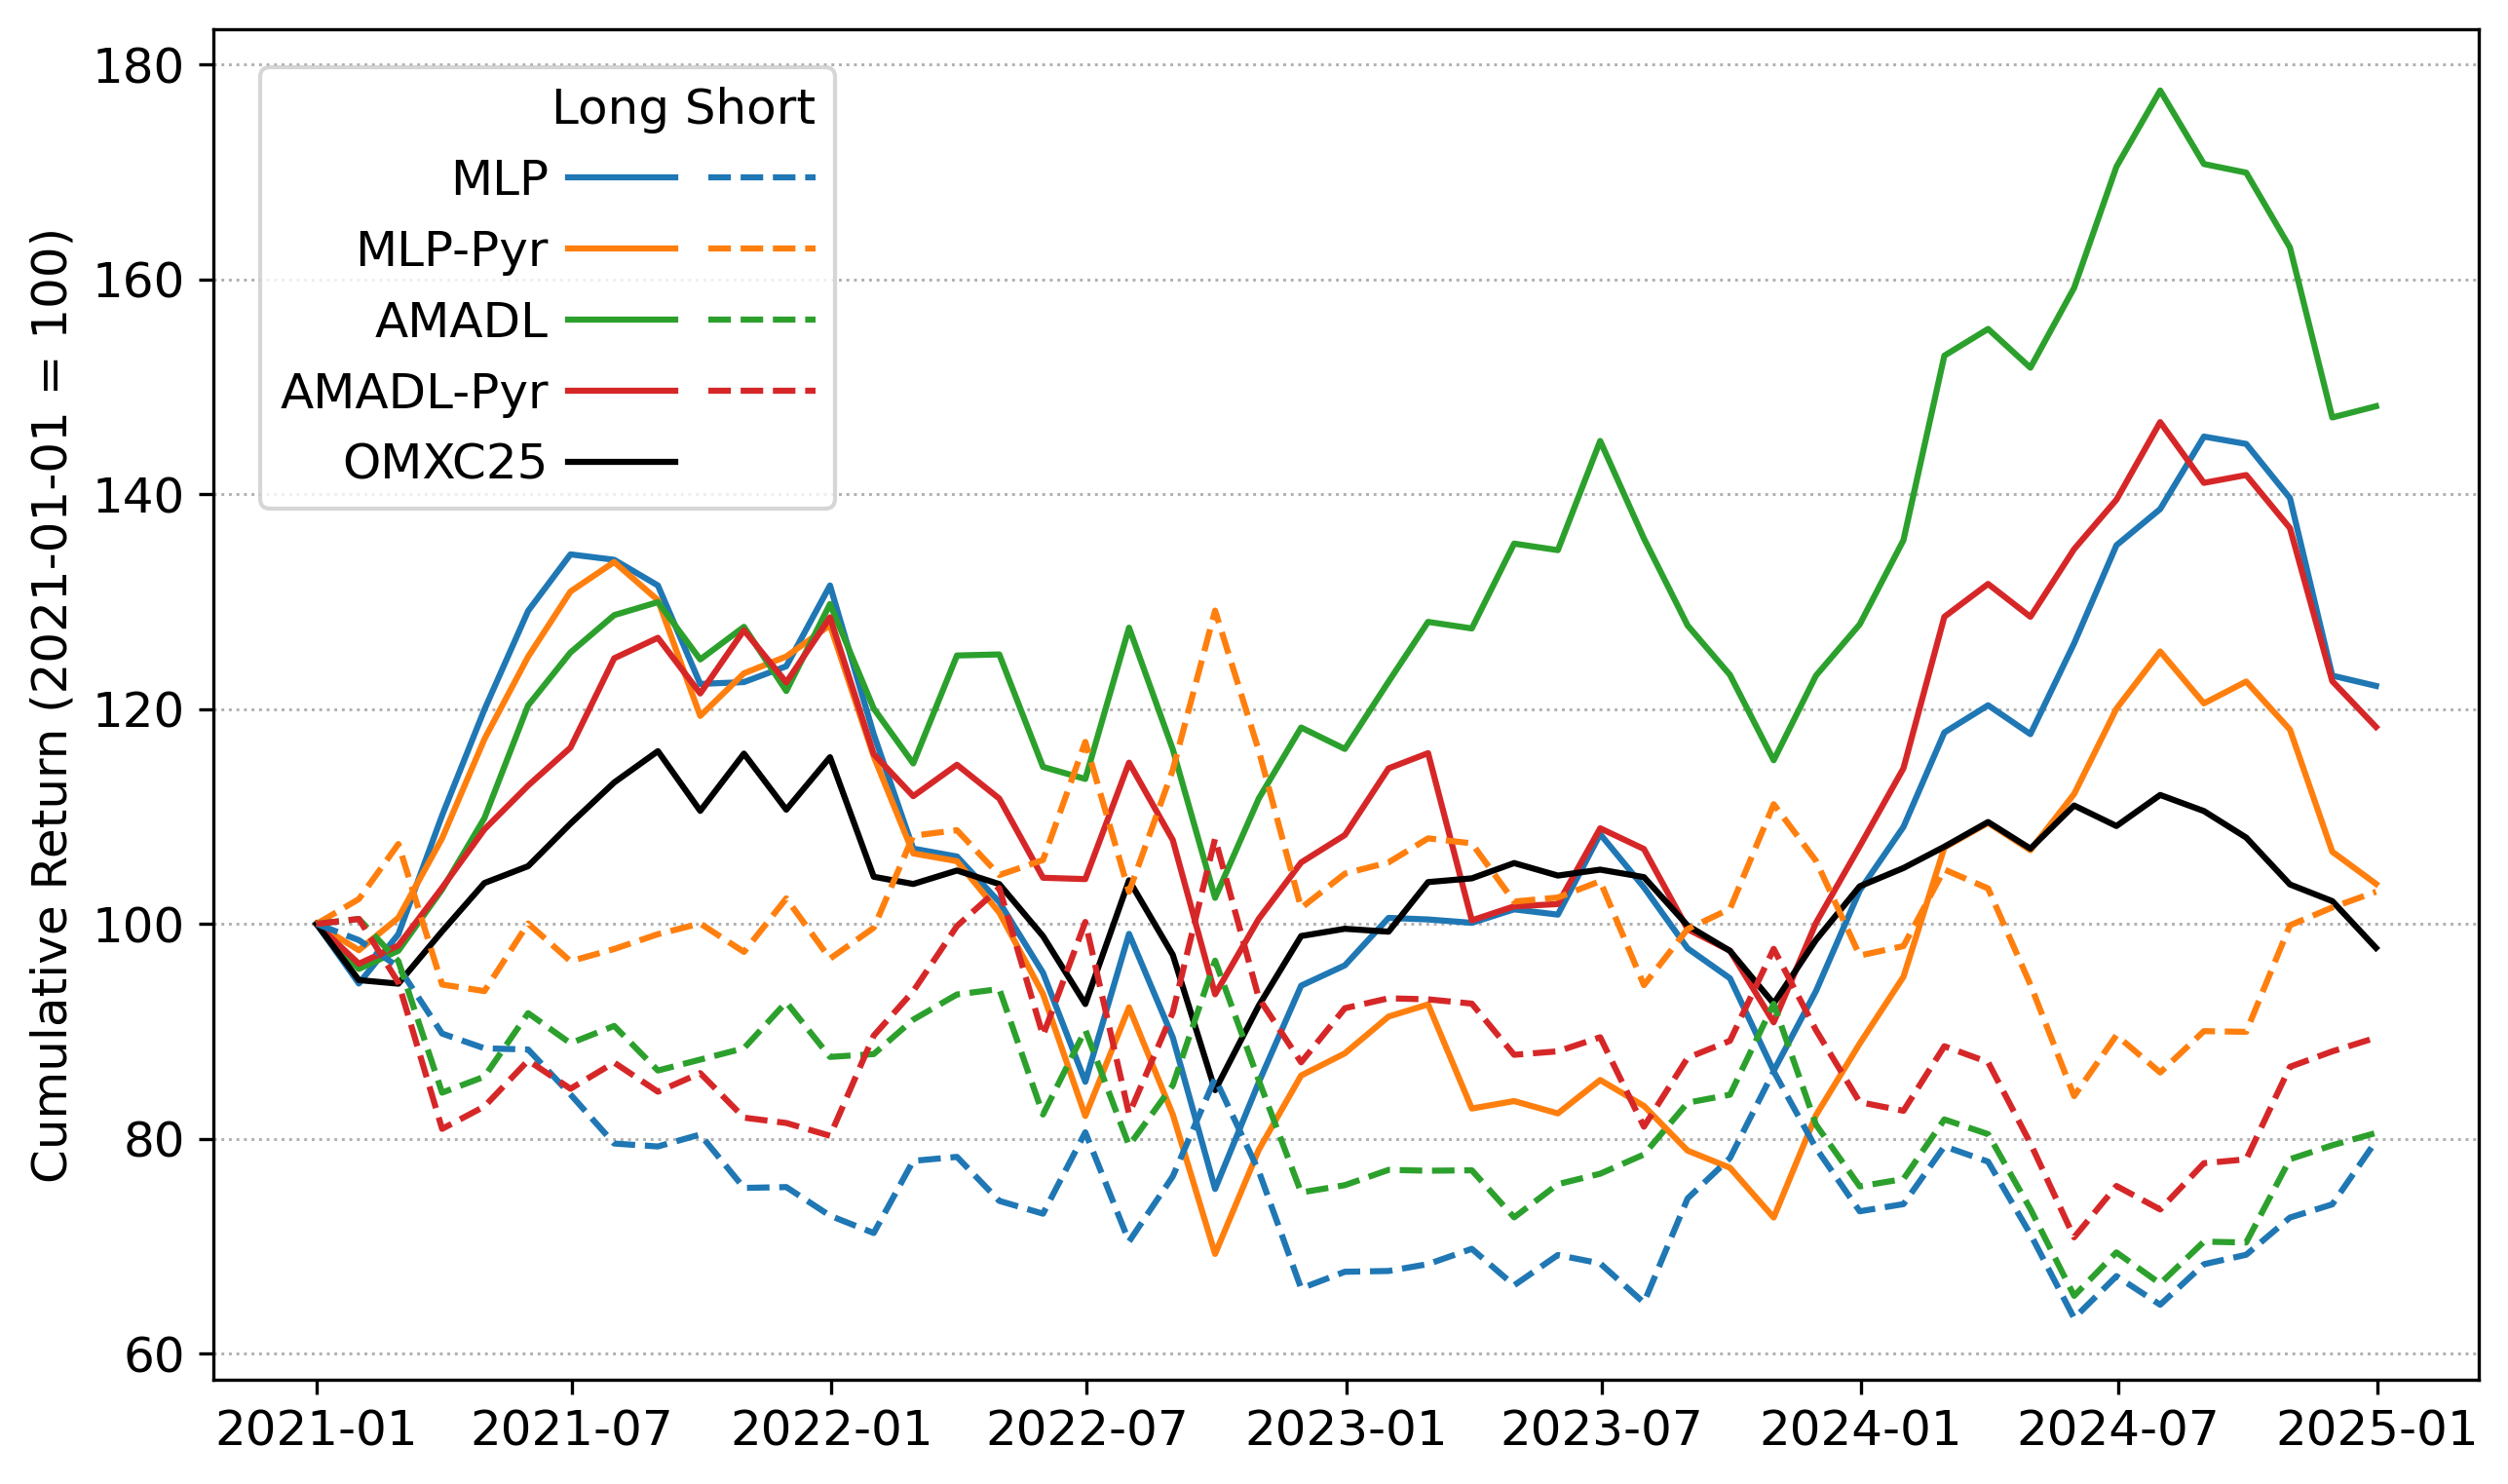

In [6]:
# plotting
fig, ax = plt.subplots(figsize=(10, 6))
default_cycler = plt.rcParams['axes.prop_cycle']
for model in models:    
    ax.plot(port_10_1['timestamp'], port_10_1[f'{model}_long_cum'], label=f'{model}', linestyle='-')
ax.plot(omxc25_price['timestamp'], omxc25_price['cumulative'], label='OMXC25', linestyle='-', color='black')
ax = plt.gca()
ax.set_prop_cycle(default_cycler)
for model in models:    
    ax.plot(port_10_1['timestamp'], port_10_1[f'{model}_short_cum'], label=f' ', linestyle='--')
ax.set_ylabel('Cumulative Return (2021-01-01 = 100)')
ax.yaxis.grid(True, which='major', linestyle=':', linewidth=0.7)

leg = ax.legend(ncol=2, loc='upper left',
                frameon=True, 
                markerfirst=False, 
                handlelength=2.2,
                handletextpad=0.4, 
                bbox_to_anchor=(0.01, 0.99, 0.275 ,0.0), 
                mode='expand', title='Long Short')
leg._legend_box.align = "right"

plt.savefig('figs/port10-1_return_amadl.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## <a id='toc4_1_'></a>[Tables](#toc0_)

### <a id='toc4_1_1_'></a>[Decile performance](#toc0_)

In [7]:
asset_ret = (
    df
    .pivot_table(
        index='timestamp',
        columns='ticker',
        values='y_true',
        aggfunc='mean'
    )
    .fillna(0)
)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
for m in models:
    # df[f'dec_{m}'] = assign_decile(df, m, n_tiles)
    df[f'dec_{m}'] = df.groupby(['timestamp'])[m].transform(lambda x: pd.qcut(x, n_tiles, labels=False)+1)

tbl_panel = {}
for m in models:
    dec_r = (
        df
        .groupby(['timestamp', f'dec_{m}'])['y_true']
        .mean()
        .unstack(f'dec_{m}')
        .sort_index()
    )
    dec_p = (
        df
        .groupby(['timestamp', f'dec_{m}'])[m]
        .mean()
        .unstack(f'dec_{m}')
        .sort_index()
    )

    records = []
    for d in range(1, n_tiles+1):
        r_ts = dec_r[d]
        p_ts = dec_p[d]
        avg = r_ts.mean()
        sd  = r_ts.std(ddof=1)
        sr  = avg/sd * np.sqrt(12)
        p   = p_ts.mean() * 100
        avg = avg * 100
        records.append({'decile':d, 'Pred, %':p, 'Avg, %':avg, 'SD':sd, 'SR':sr})

    # now H–L synthetic series
    r_hl = dec_r[n_tiles] - dec_r[1]
    p_hl = dec_p[n_tiles] - dec_p[1]
    avg = r_hl.mean()
    sd  = r_hl.std(ddof=1)
    sr  = avg/sd * np.sqrt(12)
    p   = p_hl.mean() * 100
    avg = avg * 100
    records.append({'decile':'H-L','Pred, %':p,'Avg, %':avg,'SD':sd,'SR':sr})

    df_panel = pd.DataFrame(records).set_index('decile')
    tbl_panel[m] = df_panel
    tbl_panel[m].rename(index={1: 'Low (L)'}, inplace=True)
    tbl_panel[m].rename(index={n_tiles: 'High (H)'}, inplace=True)


In [8]:
model_groups = [
    # ['OLS','LASSO'], 
                ['MLP','MLP-Pyr'], 
                ['AMADL','AMADL-Pyr']]
col_names = ['Pred, %','Avg, %','SD','SR']
tab = portfolio_panel(tbl_panel, model_groups, col_names)

tab = tab.replace('%', '\\%')

with open('tabs/portfolio_table_amadl.tex', 'w') as f:
    f.write(tab)
print(tab)

\begin{tabular}{lrrrrrrrr}
\hline \hline \\ [-1.8ex]
 & \multicolumn{4}{c}{MLP} & \multicolumn{4}{c}{MLP-Pyr} \\
 \cmidrule(lr){2-5} \cmidrule(lr){6-9}
  & Pred, \% & Avg, \% & SD & SR & Pred, \% & Avg, \% & SD & SR \\
\midrule
Low (L) & -0.085 & 0.254 & 0.066 & 0.133 & -0.252 & -0.273 & 0.065 & -0.145 \\
2 & 0.390 & 0.195 & 0.054 & 0.126 & 0.385 & 0.913 & 0.056 & 0.566 \\
3 & 0.632 & 0.545 & 0.073 & 0.260 & 0.677 & 1.387 & 0.063 & 0.758 \\
4 & 0.896 & -0.163 & 0.059 & -0.096 & 0.906 & -0.555 & 0.061 & -0.316 \\
High (H) & 1.257 & 0.674 & 0.072 & 0.323 & 1.248 & 0.325 & 0.071 & 0.159 \\
H-L & 1.342 & 0.420 & 0.063 & 0.232 & 1.500 & 0.599 & 0.066 & 0.317 \\
\midrule
 & \multicolumn{4}{c}{AMADL} & \multicolumn{4}{c}{AMADL-Pyr} \\
 \cmidrule(lr){2-5} \cmidrule(lr){6-9}
  & Pred, \% & Avg, \% & SD & SR & Pred, \% & Avg, \% & SD & SR \\
\midrule
Low (L) & 0.136 & 0.225 & 0.067 & 0.116 & 0.063 & -0.057 & 0.076 & -0.026 \\
2 & 0.571 & -0.076 & 0.067 & -0.039 & 0.544 & 0.290 & 0.064 & 0.157 \\

### <a id='toc4_1_2_'></a>[Drawdown, turnover, and max 1-month loss](#toc0_)

In [9]:
tbl_perf = {}
for m in models:
    # 1) get equal‐weighted return series for each decile
    dec_r = (
      df
      .groupby(['timestamp', f'dec_{m}'])['y_true']
      .mean()
      .unstack(f'dec_{m}')
      .sort_index()
    )
    # extract Low, High, H-L
    r_low  = dec_r[1]
    r_high = dec_r[n_tiles]
    r_hl   = r_high - r_low

    # 2) build weight matrices for each
    #    using only y_true presence to define membership
    w_low  = equal_weight_matrix(df[df[f'dec_{m}']==1], f'dec_{m}')
    w_high = equal_weight_matrix(df[df[f'dec_{m}']==n_tiles], f'dec_{m}')
    # H-L weights = long high, short low
    w_hl   = w_high - w_low

    stats = {
      'Low':  stats_for_series(r_low,  w_low, asset_ret),
      'High': stats_for_series(r_high, w_high, asset_ret),
      'H-L':  stats_for_series(r_hl,   w_hl, asset_ret),
    }

    tbl_perf[m] = pd.DataFrame(stats).T

In [10]:
col_names = ['Max DD, %', 'Max 1M loss, %', 'Turnover, %']
model_groups = [
    # ['OLS'], ['LASSO'], 
    ['MLP'], ['MLP-Pyr'], 
    ['AMADL'], ['AMADL-Pyr']]
tab_perf = portfolio_panel(tbl_perf, model_groups, col_names)
tab_perf = tab_perf.replace('%', '\\%')  # escape percent sign for LaTeX

with open('tabs/portfolio_table_dd_mloss_turn_amadl.tex', 'w') as f:
    f.write(tab_perf)
print(tab_perf)

\begin{tabular}{lrrr}
\hline \hline \\ [-1.8ex]
 & \multicolumn{3}{c}{MLP} \\
 \cmidrule(lr){2-4}
  & Max DD, \% & Max 1M loss, \% & Turnover, \% \\
\midrule
Low & 27.904 & 15.006 & 35.547 \\
High & 43.960 & 15.783 & 36.505 \\
H-L & 39.949 & 12.760 & 57.935 \\
\midrule
 & \multicolumn{3}{c}{MLP-Pyr} \\
 \cmidrule(lr){2-4}
  & Max DD, \% & Max 1M loss, \% & Turnover, \% \\
\midrule
Low & 32.795 & 12.972 & 33.451 \\
High & 48.183 & 15.783 & 37.919 \\
H-L & 34.160 & 12.129 & 64.934 \\
\midrule
 & \multicolumn{3}{c}{AMADL} \\
 \cmidrule(lr){2-4}
  & Max DD, \% & Max 1M loss, \% & Turnover, \% \\
\midrule
Low & 22.772 & 13.659 & 32.911 \\
High & 21.189 & 11.902 & 25.713 \\
H-L & 21.757 & 20.812 & 48.930 \\
\midrule
 & \multicolumn{3}{c}{AMADL-Pyr} \\
 \cmidrule(lr){2-4}
  & Max DD, \% & Max 1M loss, \% & Turnover, \% \\
\midrule
Low & 34.795 & 17.642 & 26.391 \\
High & 29.331 & 13.434 & 30.276 \\
H-L & 21.016 & 19.890 & 40.746 \\
\hline \hline
\end{tabular}
